In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

            ####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

a=6371.0e3
R=a

ncfile='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/aqua_isca5m/aqua_isca5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]
lat_nc=v_var['lat']

#### Load files

In [2]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m50      =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la5m_oc5m/*.hkl'))
m5       =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la50m_oc50m/*.hkl'))
HC10_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC10_la50m_oc5m/*.hkl'))
HC20_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC20_la50m_oc5m/*.hkl'))
HC30_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC30_la50m_oc5m/*.hkl'))

HC10_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC10_la5m_oc50m/*.hkl'))
HC20_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC20_la5m_oc50m/*.hkl'))
HC30_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC30_la5m_oc50m/*.hkl'))


#### Combine all depths

In [3]:
DEPTHS       =[m50, HC10_50_5,HC20_50_5, HC30_50_5, m5, HC10_5_50, HC20_5_50, HC30_5_50]
depth_values =[50,  1050,     2050,      3050,      5,  105,       205,       305,     ]
depth_title  =['50m',  'HCe10d5m', 'HCe20d5m', 'HCe30d5m', '5m', "HCe10d50m", 'HCe20d50m', 'HCe30d50m']

flux=[]
flux_vert=[]
div=[]
div_vert=[]
eke=[]
raw=[]
tsurf=[]
mmc_decomp=[]
mmc_decomp_vert=[]
c=5
coord=load(HC10_50_5[c])
for depth in DEPTHS:
    f=0; e=1; mmcv=2; r=3; fv=4; c=5; d=6; dv=7; mmc=8;
    raw.append(load(depth[r]))
    mmc_decomp.append(load(depth[mmc]))
    flux.append(load(depth[f]))
    flux_vert.append(load(depth[fv]))
    div.append(load(depth[d])) 
    div_vert.append(load(depth[dv]))
    eke.append(load(depth[e]))
    mmc_decomp.append(load(depth[mmc]))
    mmc_decomp_vert.append(load(depth[mmcv]))
    mmc_decomp.append(load(depth[mmc]))
        

#### Load all net energy terms in PW

In [4]:
lat=div[0]['latn']
def M(X):
    #X=X-X.mean(axis=0)[None,:]
    return X
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]
for depth in range(len(DEPTHS)):
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))    
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

#### Load all MSE transport in PW

In [5]:
TE=[]; MM=[]; SE=[]; INE=[]; EKE_vert=[]; EMF_vert=[]; TEv=[]; MMv=[]; SEv=[]; NEv=[]
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
    INE.append(TE[depth]+SE[depth]+MM[depth])
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE']))
    if (depth < len(DEPTHS)-1) :
        EKE_vert.append(eke[depth]['EKE_vert'])
        EMF_vert.append(eke[depth]['EMF_vert'])

#### Load all raw data

In [6]:
Cp=1000; L=2260*1000; g=10
Z=[]; q=[]; U=[]; T=[]; V=[]; MSE=[];
for depth in range(len(DEPTHS)):
    Z.append(M(raw[depth]['Z']))
    q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    T.append(M(raw[depth]['T']))
    MSE.append(M(raw[depth]['MSE']))

#### Integrate function

In [7]:
import scipy.integrate as integrate
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    #int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:])#int_x_r[:-1,:]) #int_x[::-1,:][1:,:]+
    return avg_int_r/10**15

#### Load terms in $Wm^{-2}$

In [8]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[]; div_TEv=[]; div_MMv=[]; div_SEv=[]; div_NEv=[]
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
        
    div_TEv.append(div_vert[depth]['TE'])
    div_SEv.append(div_vert[depth]['SE'])
    div_MMv.append(div_vert[depth]['MM'])
    div_NEv.append(div_vert[depth]['NE'])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])
    

# Average Northern and Southern Hemispheres

In [9]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE); EKE_vert=np.array(EKE_vert); EMF_vert=np.array(EMF_vert)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);
ISFC=np.array(ISFC); ITOA=np.array(ITOA); TS=np.array(TS)
TEv=np.array(TEv); SEv=np.array(SEv); MMv=np.array(MMv); NEv=np.array(NEv)
div_TEv=np.array(div_TEv); div_SEv=np.array(div_SEv); div_MMv=np.array(div_MMv); div_NEv=np.array(div_NEv)
Z=np.array(Z); q=np.array(q); U=np.array(U); T=np.array(T); V=np.array(V); MSE=np.array(MSE);



In [10]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [11]:
TE_a   ,SE_a     , MM_a  , NE_a  , EMF_vert_a,   lat_a  = N_S_avg(TE, SE, MM, NE, EMF_vert, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a = N_S_avg( ISFC,ISFC,ISFC,ISFC,ISFC, lat[1:-1] )[0]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]
EKE_vert_a  = N_S_avg( EKE_vert  ,EKE_vert,EKE_vert ,EKE_vert ,EKE_vert , lat, flux_flag=1 )[0]

TEv_a  ,SEv_a    , MMv_a  , NEv_a    ,ignore,  lat_a = N_S_avg(TEv, SEv, MMv, NEv,NEv, lat)
CpTv_a  ,gZv_a    , Lqv_a  , MSEv_a    ,ignore,  lat_a = N_S_avg(Cp*T, g*Z, L*q, Cp*T+g*Z+L*q,Cp*T, lat, 1)


In [12]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_vert(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(13):
            div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div


div_CpT=spher_div_vert(CpTv_a)
div_gZ=spher_div_vert(gZv_a)
div_Lq=spher_div_vert(Lqv_a)
div_MSE=spher_div_vert(MSEv_a)

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

#### Calculate divergence

In [13]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(x.shape[0]):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a
div_EMF_vert_a=spher_div(EMF_vert_a*10**10, np.cos(np.radians(lat_a)) )

#### Find the storm track position

In [14]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):           
            l_range=((lat_a>=30) & (lat_a<=60))                
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [15]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X= storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)

I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)

# Shift decompose

In [16]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    div_SE_a=spher_div(SE_a*10**15)
    div_MM_a=spher_div(MM_a*10**15)
    div_NE_a=div_TE_a+div_SE_a+div_MM_a
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [17]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(-1.0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [18]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nan
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 0.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

In [19]:
def plot_flux(d,threshold_value) :
    
    n=d+1
    pos=storm_pos
    
    mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),0)
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       y= np.roll(y,0,axis=-1)  
       return y
    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, threshold_value)
    latns=lat

    py.subplot(3,4,n)
    b = py.contourf(range(13),lat_a,add(TE_a[d,...]), v, cmap=BuRd); 
    c=py.contour(range(13),lat_a, add(TE_a[d,...]), v, colors='k',linewidths=1.0);    
    py.plot(range(13), np.roll((pos[d,:]),0), 'ro-')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth_values[d])+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,80)

In [20]:
# fig=py.figure(figsize=(20, 10))
# for d in range(len(DEPTHS)):
#     plot_flux(d,1.0)

# Decompose Net energy in Watts/m^2

In [21]:
swabs=np.array(swabs); shf=np.array(shf); ne=np.array(ne); olr=np.array(olr); dhdt=np.array(dhdt);
SW_sfc=np.array(SW_sfc); LW_sfc=np.array(LW_sfc); SW_toa=np.array(SW_toa); shflx=np.array(shflx); lhflx=np.array(lhflx);
sfc=np.array(sfc); toa=np.array(toa); 

In [22]:
SWABS_a, SHF_a  , NE_a , OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]

In [23]:
def inerp_at_mean(flux,lat):
  D = np.zeros(((len(DEPTHS),13)))
  for d in range(0,(len(DEPTHS))):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=np.nanmean(zero_div_TE[d,:-1])
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [24]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

In [25]:
P_SWAB =inerp_at_max(SWABS_a,lat_a)
P_SHF  =inerp_at_max(SHF_a,lat_a)
P_NE   =inerp_at_max(NE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

P_SWsfc = inerp_at_max(SW_sfc_a,lat_a)
P_LWsfc = inerp_at_max(LW_sfc_a,lat_a)
P_SWtoa = inerp_at_max(SW_toa_a,lat_a)
P_shflx = inerp_at_max(shflx_a,lat_a)
P_lhflx = inerp_at_max(lhflx_a,lat_a)

P_sfc = inerp_at_max(sfc_a,lat_a)
P_toa = inerp_at_max(toa_a,lat_a)

# First figure

In [34]:
def compare_plot(de1,de2,X,c,T,month_to_month=1,l=3,d=0):
    
    de_values=np.array(depth_values)
    d1=np.squeeze(np.where((de_values)==de1))
    d2=np.squeeze(np.where((de_values)==de2))
    depth_title  =['50m',  'HCe10d5m', 'HCe20d5m', 'HCe30d5m', '5m', "HCe10d50m", 'HCe20d50m', 'HCe30d50m']
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
        
    py.plot(range(13),D(X[d1,:]),c+'o-'   ,label=(depth_title[d1]),lw=3.5)             
    py.plot(range(13),D(X[d2,:]),c+'o--'  ,label=(depth_title[d2]),lw=3.5)
       
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=35)
    #if n==1:
    py.legend(loc='best',fontsize=32,ncol=1,frameon=False)    
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=40)
    py.xticks(range(13), mticks,size=37)
    py.yticks(np.arange(-6,6+2,2),size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.40, hspace=0.3)
    py.tight_layout()


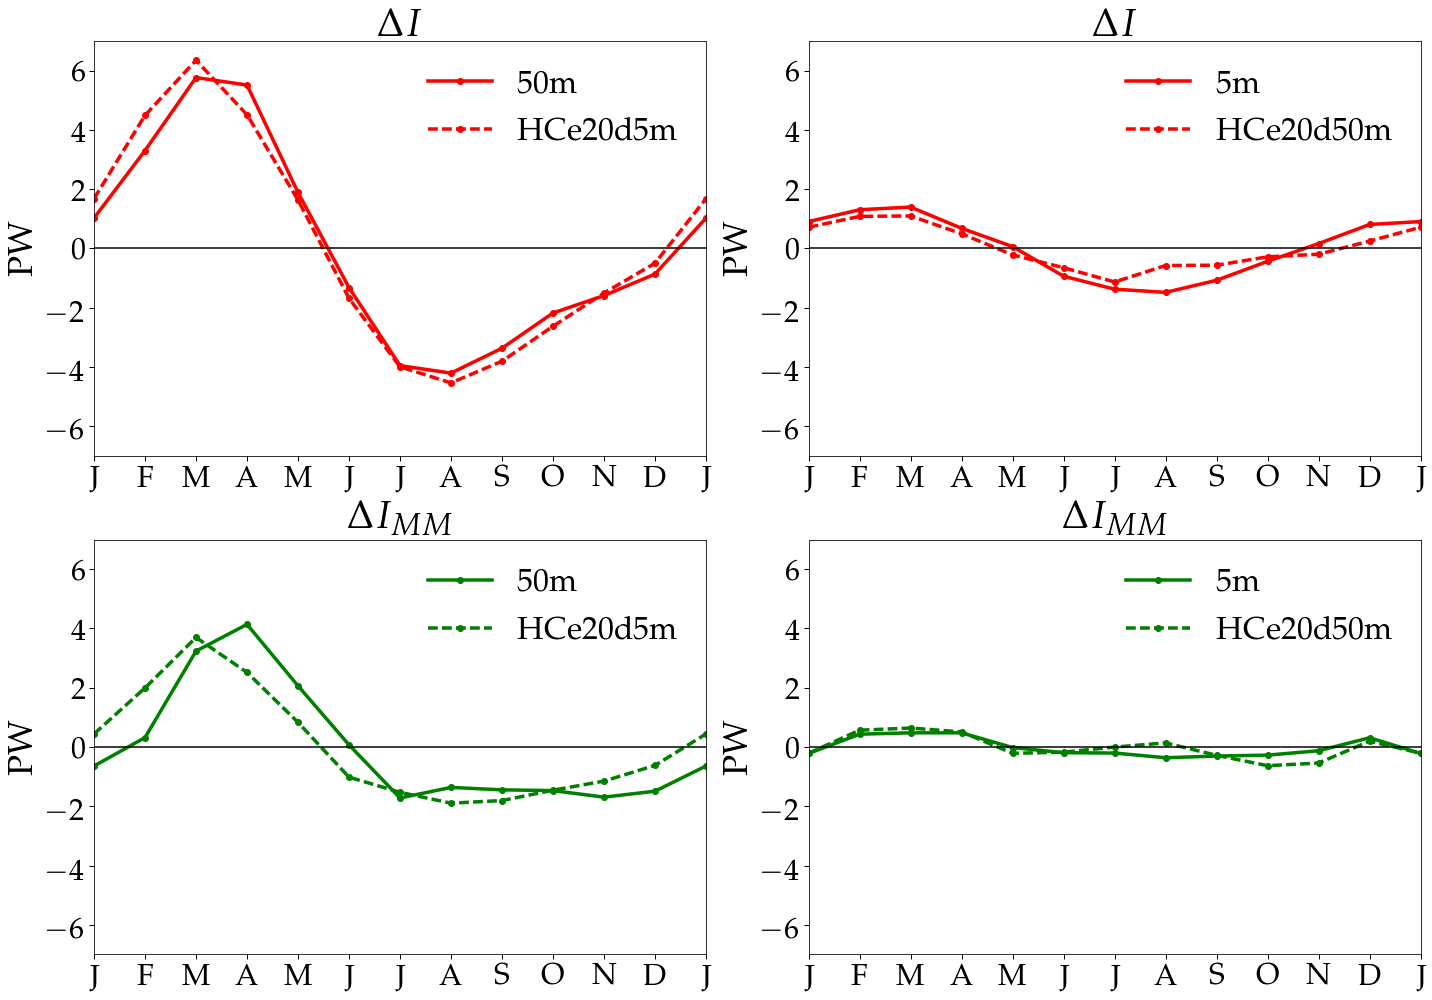

In [36]:
py.figure(figsize=(20,14))

py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.subplot(2,2,1)
compare_plot(50,2050,Intensity_te,'r',r'$\Delta I$',month_to_month=0,l=7)
py.subplot(2,2,3)
compare_plot(50,2050,-Intensity_mm,'g',r'$\Delta I_{MM}$',month_to_month=0,l=7)
py.subplot(2,2,2)
compare_plot(5,205,Intensity_te,'r',r'$\Delta I$',month_to_month=0,l=7)
py.subplot(2,2,4)
compare_plot(5,205,-Intensity_mm,'g',r'$\Delta I_{MM}$',month_to_month=0,l=7)
py.tight_layout()

py.savefig('Jan7/Appendix_HC_edge.pdf')